# **ASM2 -- ResNet**

In [ ]:
# import libraries
from keras.datasets import cifar100
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, optimizers, datasets, regularizers
import numpy as np
import random
from sklearn import metrics

In [ ]:
# load cifar100
(x_img_train,y_label_train), (x_img_test, y_label_test)=cifar100.load_data()
y_label_train = tf.squeeze(y_label_train)
y_label_test = tf.squeeze(y_label_test)
print(x_img_train.shape, y_label_train.shape, x_img_test.shape, y_label_test.shape)

## **Pre-processing**

### **Normilization**

In [ ]:
#z-score normilization
mean = np.mean(x_img_train, axis=(0, 1, 2, 3))
std = np.std(x_img_train, axis=(0, 1, 2, 3))

x_img_train = (x_img_train - mean) / (std + 1e-7)#trick avoid integer
x_img_test = (x_img_test - mean) / (std + 1e-7) 

### **Split dataset**

In [ ]:
# split trainning and validation set
(x_img_train, x_img_valid) = x_img_train[5000:], x_img_train[:5000]
(y_label_train, y_label_valid) = y_label_train[5000:], y_label_train[:5000]

### **one-hot encode**

In [ ]:
#one-hot encode
y_label_train = tf.keras.utils.to_categorical(y_label_train, 100)
# y_label_test = tf.keras.utils.to_categorical(y_label_test, 100)

### **Transfer to dataset**

In [ ]:
batchsz = 128

def preprocess(x, y):
    x = tf.pad(x, [[4, 4], [4, 4], [0, 0]]) # [40, 40, 3]
    x = tf.image.random_crop(x, [32, 32, 3])
    x = tf.image.random_flip_left_right(x)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

# transfer to dataset
train_db = tf.data.Dataset.from_tensor_slices((x_img_train, y_label_train))
train_db = train_db.shuffle(5000).map(preprocess).batch(batchsz)

valid_db = tf.data.Dataset.from_tensor_slices((x_img_valid, y_label_valid))
valid_db = valid_db.map(preprocess).batch(batchsz)

test_db = tf.data.Dataset.from_tensor_slices((x_img_test, y_label_test))
test_db = test_db.map(preprocess).batch(batchsz)

## **ResNet model**

In [ ]:
class BasicBlock(layers.Layer):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same',
                         use_bias=False)
        
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same',
                         use_bias=False)
        self.bn2 = layers.BatchNormalization()

        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = Sequential([layers.Conv2D(self.expansion * out_channels, kernel_size=1, strides=stride, padding='same',
                         use_bias=False),
                                        layers.BatchNormalization()])
        else:
            self.shortcut = lambda x, _: x

    def call(self, inputs, training=False):

        out = self.conv1(inputs)
        out = self.bn1(out, training=training)
        out = tf.nn.relu(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)

        out = out + self.shortcut(inputs, training)
        out = tf.nn.relu(out)

        return out
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'conv1': self.conv1,
            'bn1': self.bn1,
            'conv2': self.conv2,
            'bn2': self.bn2,
            'shortcut': self.shortcut
        })
        return config

def build_resblock(BasicBlock, out_channels, num_blocks, stride):
    in_channels = 64
    strides = [stride] + [1] * (num_blocks - 1)
    res_blocks =Sequential()

    for stride in strides:
        res_blocks.add(BasicBlock(64, out_channels, stride))
        in_channels = out_channels

    return res_blocks

model = tf.keras.Sequential()

model.add(layers.Conv2D(64, input_shape=(32, 32, 3), kernel_size=3, strides=1, padding='same',use_bias=False))
model.add(layers.BatchNormalization())

model.add(build_resblock(BasicBlock, 64,   2, stride=1))
model.add(build_resblock(BasicBlock, 128,  2, stride=2))
model.add(build_resblock(BasicBlock, 256,  2, stride=2))
model.add(build_resblock(BasicBlock, 512,  2, stride=2))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(100))

## **Train**

In [ ]:
model.summary()

# lr = 0.1
optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4)
variables = model.trainable_variables
print(len(variables))

# def lr_schedule(epoch):
#     if epoch < 60:
#         return 0.1
#     if epoch < 120:
#         return 0.02


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1728      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
sequential_6 (Sequential)    (None, 32, 32, 64)        148480    
_________________________________________________________________
sequential_7 (Sequential)    (None, 16, 16, 128)       543744    
_________________________________________________________________
sequential_10 (Sequential)   (None, 8, 8, 256)         2168832   
_________________________________________________________________
sequential_13 (Sequential)   (None, 4, 4, 512)         8663040   
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def train(train_db):
  for step, (x, y) in enumerate(train_db):
      with tf.GradientTape() as tape:
          logits = model(x, training=True)
        
          loss = tf.reduce_mean(tf.losses.categorical_crossentropy(y, logits, from_logits=True))
          loss_regularization = []
          for p in variables:
              loss_regularization.append(tf.nn.l2_loss(p))
          loss_regularization = tf.reduce_sum(tf.stack(loss_regularization))
          loss = loss + 5e-4 * loss_regularization

      grads = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(grads, variables))
      # lr = lr_schedule(epoch)
      if step % 100 == 0:
          print('epoch:', epoch, 'step:', step, 'loss:', float(loss), 'lr:', 0.1)

def eva(db):
  total_num = 0
  total_correct = 0
  preds = []
  ys = []
  accs = []
  for x, y in db:
      out = model(x, training=False)
           
      prob = tf.nn.softmax(out, axis=1)
      pred = tf.argmax(prob, axis=1) 
      pred = tf.cast(pred, dtype=tf.int32)
      for i in pred:
        preds.append(i)
      for j in y:
        ys.append(j)

      correct = tf.cast(tf.equal(pred, y), dtype=tf.int32)
      correct = tf.reduce_sum(correct)
      total_num += x.shape[0]
      total_correct += int(correct)

  acc = total_correct / total_num
  accs.append(acc)
  print('epoch:', epoch, 'test_acc:', acc)
  return accs,preds,ys

valid = []
for epoch in range(60):
  train(train_db)
  valid_acc = eva(valid_db)
  valid.append(valid_acc)

epoch: 0 step: 0 loss: 7.522778511047363 lr: 0.1
epoch: 0 step: 100 loss: 6.500988006591797 lr: 0.1
epoch: 0 step: 200 loss: 6.038971900939941 lr: 0.1
epoch: 0 step: 300 loss: 5.904415130615234 lr: 0.1
epoch: 0 test_acc: 0.0892
epoch: 1 step: 0 loss: 5.4666290283203125 lr: 0.1
epoch: 1 step: 100 loss: 5.3607025146484375 lr: 0.1
epoch: 1 step: 200 loss: 5.141288757324219 lr: 0.1
epoch: 1 step: 300 loss: 4.6574296951293945 lr: 0.1
epoch: 1 test_acc: 0.168
epoch: 2 step: 0 loss: 4.454799652099609 lr: 0.1
epoch: 2 step: 100 loss: 4.272558689117432 lr: 0.1
epoch: 2 step: 200 loss: 3.963714599609375 lr: 0.1
epoch: 2 step: 300 loss: 4.022198677062988 lr: 0.1
epoch: 2 test_acc: 0.2694
epoch: 3 step: 0 loss: 3.842207908630371 lr: 0.1
epoch: 3 step: 100 loss: 3.8225531578063965 lr: 0.1
epoch: 3 step: 200 loss: 3.454439640045166 lr: 0.1
epoch: 3 step: 300 loss: 3.5176806449890137 lr: 0.1
epoch: 3 test_acc: 0.3182
epoch: 4 step: 0 loss: 3.477841854095459 lr: 0.1
epoch: 4 step: 100 loss: 3.11856675

## **Test**

In [ ]:
accs,preds,ys = eva(test_db)

epoch: 0 test_acc: 0.7072


## **Save as H5**

In [ ]:
model.save('resnet.h5')

## **Class labels**

In [ ]:
labelNames =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

-----------------ResNet Report (pca+hog)---------------
F1 score: 0.7064131751402228
Accuracy score: [0.7072]
Confusion matrix: 
 [[85  0  0 ...  0  0  0]
 [ 0 79  0 ...  0  0  0]
 [ 0  0 66 ...  0  2  0]
 ...
 [ 0  0  0 ... 75  0  0]
 [ 0  0  4 ...  0 47  1]
 [ 0  0  0 ...  0  0 73]]
Plotting confusion matrix


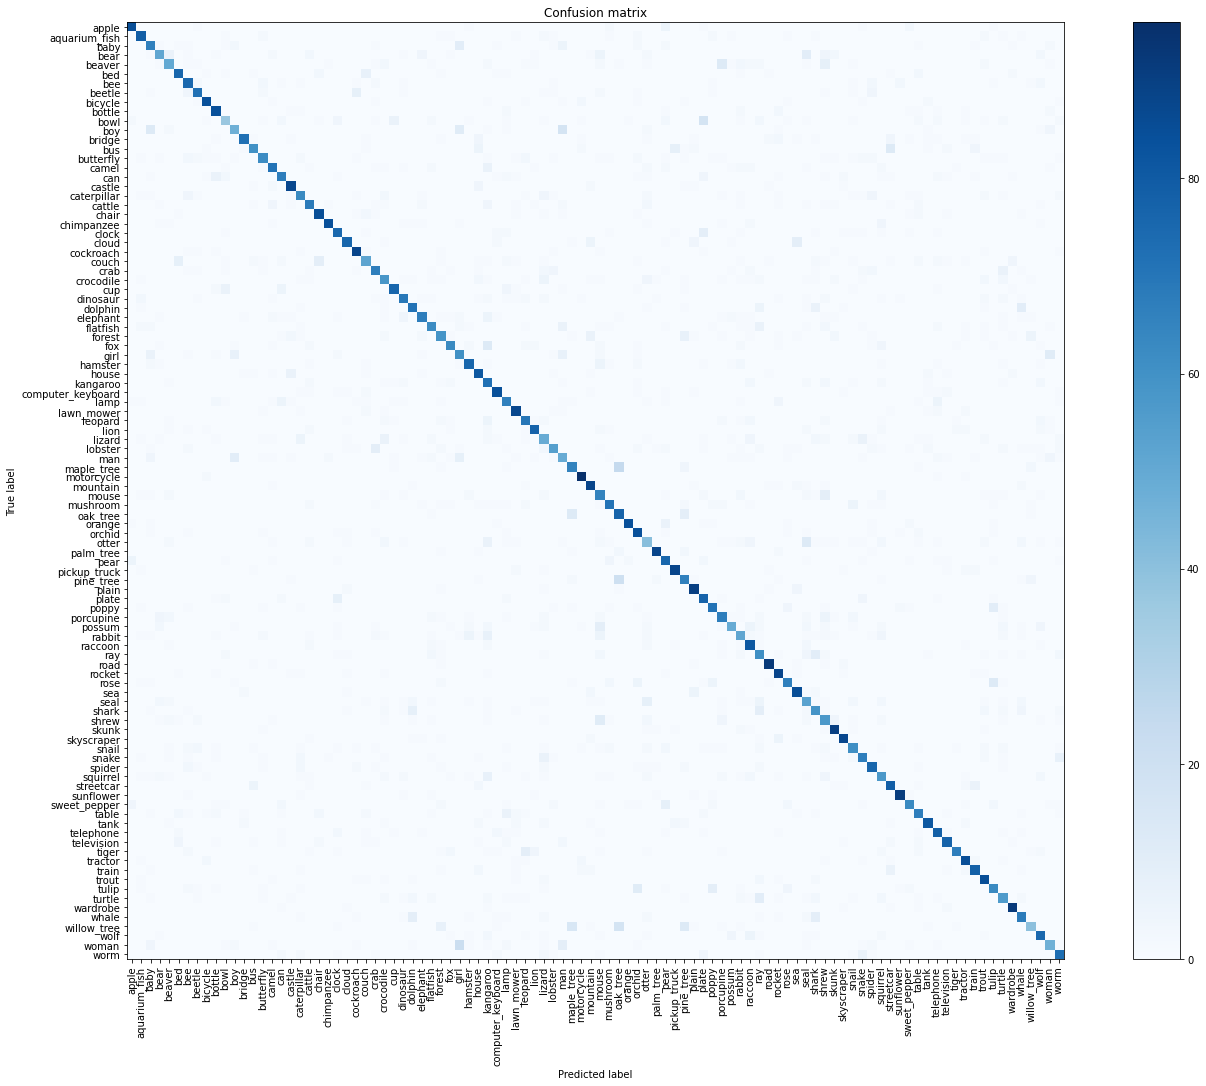

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       100
           1       0.79      0.79      0.79       100
           2       0.59      0.66      0.63       100
           3       0.69      0.51      0.59       100
           4       0.64      0.50      0.56       100
           5       0.78      0.76      0.77       100
           6       0.68      0.75      0.71       100
           7       0.79      0.72      0.75       100
           8       0.87      0.84      0.85       100
           9       0.76      0.84      0.80       100
          10       0.61      0.37      0.46       100
          11       0.64      0.47      0.54       100
          12       0.90      0.72      0.80       100
          13       0.77      0.60      0.67       100
          14       0.73      0.62      0.67       100
          15       0.74      0.71      0.72       100
          16       0.70      0.67      0.68       100
          17       0.82    

In [ ]:
# ResNet report and analysis

# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

res_f1 = metrics.f1_score(ys, preds, average= "weighted")
res_cm = metrics.confusion_matrix(ys, preds)
print("-----------------ResNet Report---------------")
print("F1 score: {}".format(res_f1))
print("Accuracy score: {}".format(accs))
print("Confusion matrix: \n", res_cm)
print('Plotting confusion matrix')

plt.figure(figsize = (20,15))
plot_confusion_matrix(res_cm, labelNames)
plt.savefig('resnet_confusion_metrics.png',figsize = (20,15))
plt.show()

print(metrics.classification_report(ys, preds))